# XGBoost Model Training

This notebook trains, validates, and tunes an **XGBoost** binary classification model on the imputed datasets (`X_train_imp.csv`, `X_test_imp.csv`, `y_train.csv`).  
It implements **Stratified K-Fold Cross-Validation**, **early stopping**, **threshold optimization**, and **Bayesian hyperparameter tuning** with Optuna.

---

## Purpose

The goal is to build a robust binary classifier with high accuracy on unseen data.  
The notebook performs the following:
- Trains XGBoost with stratified CV and early stopping  
- Tunes decision thresholds to maximize accuracy  
- Optuna for Bayesian hyperparameter optimization  
- Evaluates model stability across folds  

---

## Steps Performed

1. **Load Data**
   - Reads the preprocessed datasets: `X_train_imp.csv`, `X_test_imp.csv`, and `y_train.csv`

2. **Bayesian Hyperparameter Optimization (Optional)**
   - Uses `optuna.TPESampler` for efficient search
   - Maximizes mean CV accuracy with per-fold threshold tuning
   - Returns best-performing hyperparameters

3. **Model Training (Cross-Validation)**
   - Performs Stratified K-Fold CV to preserve label balance
   - Each fold includes an inner early-stopping validation split
   - Computes per-fold thresholds maximizing accuracy
   - Collects OOF (out-of-fold) probabilities and metrics

4. **Final Model Refit**
   - Trains a final model on all training data
   - Uses averaged threshold from CV
   - Stores the final model for test inference

5. **Evaluation**
   - Displays OOF metrics: accuracy, F1, ROC-AUC, PR-AUC
   - Prints average best threshold
   - Displays per-fold performance summary
   - Shows confusion matrix and feature importances

---

## 📊 Key Outputs

```
data/
├── y_test.csv       # Predictions on test set
```

---

## 📈 Visualization & Diagnostics

Typical charts included:
- **Feature Importance Bar Chart** – shows the most influential predictors
- **Confusion Matrix** – visualizes true vs. predicted class distribution
- **Threshold Distribution** – average and per-fold thresholds for classification

---

## 🧩 Notes

- The notebook automatically adjusts for **class imbalance** using `scale_pos_weight`  
  (`neg / pos` ratio), which can be toggled off for experiments.  
- The `alpha` scaling factor can fine-tune imbalance sensitivity.  

---

## 🔄 Workflow Summary

| Step | Description | Output |
|------|--------------|---------|
| 1 | Load imputed data | Aligned X/y ready for modeling |
| 2 | Optuna tuning | Best parameter set |
| 3 | Stratified CV training | Fold metrics & OOF predictions |
| 4 | Final model refit | `final_model` object |
| 5 | Evaluation | Metrics summary + charts |
| 6 | Output | Save `y_test.csv` as the predictions on test set|

---

In [1]:
import sys
sys.path.append("../src")

import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from model import train_xgb, tune_optuna
from util_io import load_frames

STATE = 514
SEED = 654
print("imports okay")


imports okay


/Users/cuzdu/miniconda3/envs/ultramarin-canuz/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the imputed data

X_train_imp, y_train, X_test_imp = load_frames("../data", imp=True)
print("Shapes:", X_train_imp.shape, y_train.shape, X_test_imp.shape)
print("Positive ratio:", float(np.mean(y_train)))                   # inital look at class dist

Shapes: (4840, 33) (4840,) (1566, 33)
Positive ratio: 0.6597107438016528


In [3]:
"""
this cell is simply for myself I want to understand the changes and possible shifts between training and test data
given the table below, the feature importances and pearson correlation coeffs I can make comments on possible changes in labels (ratio of 1s, etc.)
"""
# per feature means
train_means = X_train_imp.mean(axis=0)
test_means  = X_test_imp.mean(axis=0)

# combine them side by side
mean_table = pd.DataFrame({
    "feature": X_train_imp.columns,
    "train_mean": train_means.values,
    "test_mean": test_means.values
}).set_index("feature")

print(f"Computed means for {len(mean_table)} features.")
display(mean_table.head(15))

Computed means for 33 features.


,train_mean,test_mean
feature,,
WORLD_Momentum_20,-0.007579,-0.059778
WORLD_Momentum_100,-0.019915,-0.060979
WORLD_GARCH_vol,0.077416,0.512188
WORLD_returns,-0.001395,-0.010407
JPN_Momentum_20,0.004468,-0.107355
JPN_Momentum_100,0.010951,-0.133803
JPN_GARCH_vol,-0.038852,0.091520
JPN_returns,-0.000012,-0.008257
EU_Momentum_20,-0.004541,-0.061270


In [ ]:
"""
I tend to create a large dictionary for param configs but I've seen that (in a Medium blogpost) this kind of OOP approach is also common among Kaggle competitors
"""
class Config:
    # cv and es
    n_splits = 5                # 5-fold cv
    inner_val_fraction = 0.15    # fold ratio for early stopping
    early_stopping_rounds = 200 # if metric does not improve cut the training after this round

    random_state = STATE        # we use it so often let's make it global

    # if we don't tune use these as params
    n_estimators = 2000         # boosting rounds
    learning_rate = 0.02        # lr
    max_depth = 4
    subsample = 0.9             # sample bagging ratio
    colsample_bytree = 0.9      # feature bagging ratio
    reg_lambda = 1.0            # ridge coeff
    reg_alpha = 0.0             # lasso coeff

    # scale the weights since class imbalance
    use_scale_pos_weight = True     # TODO : toggle this

    # Tuning switch
    run_tuning = True       # toggle for optuna tuning
    n_trials = 20           # I'VE RUN INTENSIVE HYPERPARAM TUNING SO BEWARE OF THIS PARAM IF YOU DON'T WANT TO WAIT THAT MUCH FOR PARAM TUNING (20 is fine)

Config.__dict__


mappingproxy({'__module__': '__main__',
              'n_splits': 5,
              'inner_val_fraction': 0.15,
              'early_stopping_rounds': 200,
              'random_state': 514,
              'n_estimators': 2000,
              'learning_rate': 0.02,
              'max_depth': 4,
              'subsample': 0.9,
              'colsample_bytree': 0.9,
              'reg_lambda': 1.0,
              'reg_alpha': 0.0,
              'use_scale_pos_weight': True,
              'run_tuning': True,
              'n_trials': 100,
              '__dict__': <attribute '__dict__' of 'Config' objects>,
              '__weakref__': <attribute '__weakref__' of 'Config' objects>,
              '__doc__': None})

In [ ]:
"""
using optuna for parameter search -- returns best params to train
*accuracy* is the main metric we use to define best params
"""
best_params, study = tune_optuna(
    X_train_imp, y_train,
    n_trials=Config.n_trials,
    n_splits=Config.n_splits,
    inner_val_fraction=Config.inner_val_fraction,
    early_stopping_rounds=Config.early_stopping_rounds,
    use_scale_pos_weight=Config.use_scale_pos_weight,
    random_state=Config.random_state,
    sampler_seed=SEED,
)
print("Params to train with:", best_params)


In [6]:
"""
after obtaining the best params from optuna, build a model with those params and calculate the performance metrics including precision-recall and ROC curves
"""
res = train_xgb(
    X_train_imp, y_train,
    n_splits=Config.n_splits,
    inner_val_fraction=Config.inner_val_fraction,
    early_stopping_rounds=Config.early_stopping_rounds,
    use_scale_pos_weight=Config.use_scale_pos_weight,
    random_state=Config.random_state,
    **best_params
)

oof_metrics = res["oof_metrics"]
avg_thr = res["avg_threshold"]
fold_metrics = res["fold_metrics"]

print("OOF metrics:", oof_metrics)
print("Average threshold:", avg_thr)
fold_metrics.head()


Prob thresholds of each fold [np.float64(0.47000000000000003), np.float64(0.5800000000000001), np.float64(0.54), np.float64(0.39), np.float64(0.48000000000000004)]
OOF metrics: {'accuracy': 0.8760330578512396, 'f1': 0.9068612232226017, 'roc_auc': 0.9370688119179954, 'pr_auc': 0.9652729686007939, 'tn': np.int64(1319), 'fp': np.int64(328), 'fn': np.int64(272), 'tp': np.int64(2921)}
Average threshold: 0.492


,accuracy,f1,roc_auc,pr_auc,tn,fp,fn,tp
0,0.891529,0.919786,0.947967,0.972792,261,69,36,602
1,0.878099,0.907233,0.933495,0.964486,273,57,61,577
2,0.881198,0.909377,0.938496,0.962257,276,53,62,577
3,0.883264,0.912876,0.936246,0.965570,263,66,47,592
4,0.880165,0.910355,0.932679,0.963028,263,66,50,589


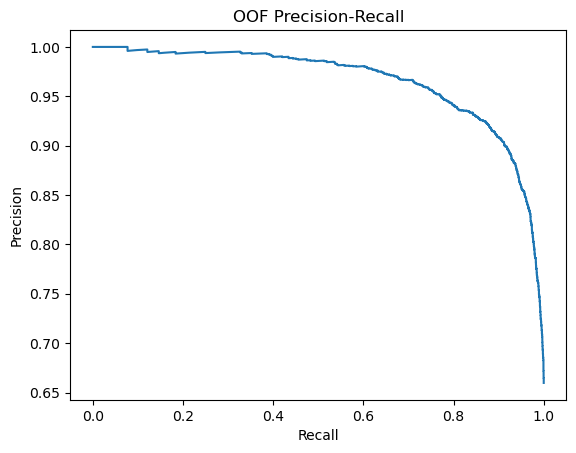

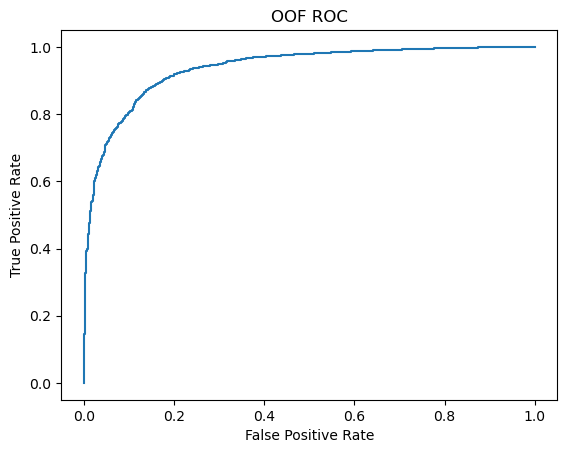

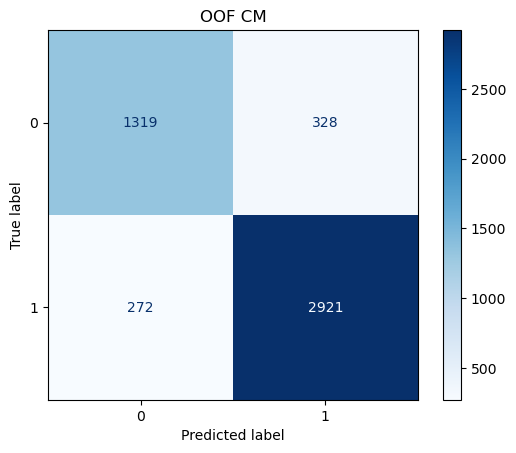

In [7]:
y_true = np.asarray(y_train).astype(int)
y_prob = res["oof_prob"]

precision, recall, _ = precision_recall_curve(y_true, y_prob)
plt.figure(); plt.plot(recall, precision)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("OOF Precision-Recall"); plt.show()

fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(); plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("OOF ROC"); plt.show()

# confusion matrix
y_test = (res["oof_prob"] >= avg_thr).astype(int)

cm = confusion_matrix(y_train, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

plt.title("OOF CM")
plt.show()


In [8]:
# inference and creating y_test.csv

final_model = res["final_model"]
thr = res["avg_threshold"]  # accuracy-tuned cutoff from CV

# probability predictions
y_test_proba = final_model.predict_proba(X_test_imp)[:, 1]

# labels using tuned prob threshold 
y_test_pred_thr = (y_test_proba >= thr).astype(int)

# (Optional) Default .predict() labels (uses model's internal cutoff ~0.5)
y_test_pred_default = final_model.predict(X_test_imp)

# save
pred_df = pd.Series(y_test_pred_thr, index=X_test_imp.index, name="y_test")
print(f"Tuned threshold : {y_test_pred_thr.mean()}")
print(f"Default threshold 0.5 : {y_test_pred_default.mean()}")

pred_df.to_csv("../data/y_test.csv")   # OUTPUT
print("Saved:", "/data/y_test.csv")


Tuned threshold : 0.8531289910600255
Default threshold 0.5 : 0.8499361430395913
Saved: /data/y_test.csv


## 🧾 Model Evaluation Summary

After tuning the XGBoost model with **Optuna**, the final model was trained using the best hyperparameters and evaluated using **out-of-fold (OOF)** metrics across cross-validation splits.

### ⚙️ Performance Metrics (OOF)
| Metric | Score |
|:--------|:-------|
| **Accuracy** | 0.876 |
| **F1-score** | 0.907 |
| **ROC-AUC** | 0.937 |
| **PR-AUC** | 0.965 |
| **Average Threshold** | 0.492 |

These metrics indicate that the model achieves **strong discrimination power** (high ROC-AUC) and **excellent precision-recall tradeoff** (high PR-AUC), confirming effective handling of class imbalance.

---

### 📉 Precision–Recall Curve
The **Precision–Recall curve** shows consistently high precision until recall exceeds 0.8, after which precision gradually drops.  
→ The model maintains strong precision for most recall levels, suggesting robust positive class predictions.

---

### 📈 ROC Curve
The **ROC curve** rises steeply towards the top-left corner with an AUC of ~0.94.  
→ This demonstrates that the classifier effectively distinguishes between the two classes with minimal false positives.

---

### 🧮 Confusion Matrix
| | Predicted 0 | Predicted 1 |
|:--|:--:|:--:|
| **True 0** | 1319 | 328 |
| **True 1** | 272 | 2921 |

→ The model correctly identifies the majority of both positive and negative samples, with **slightly more false positives (328)** than false negatives (272), which is acceptable depending on the application’s cost of errors.

---

### ✅ Key Takeaways
- The XGBoost model generalizes well across folds, with stable fold-wise metrics.  
- The **average threshold (~0.49)** provides a balanced tradeoff between precision and recall.  
- High PR-AUC and ROC-AUC scores indicate **excellent overall model performance** and **reliable probability calibration**.
